In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import os
import pandas as pd
import numpy as np

path_git = '/content/ProgettoFVAB'
filename = '4_7'
path_drive = 'C:/Users/CasaLab1/Desktop/Casillo&Natale'
dataset_dir = 'dataset_4_7/datasetCSV'
LANGUAGES = {
    4:'Spagnolo',
  7: 'Giapponese'}
LANGUAGES_N = {
    4:0,
    7:1
}
"""LANGUAGES = {1:'Italiano',
    4:'Spagnolo',
  7: 'Giapponese'}
LANGUAGES_N = {
    1:0,
    4:1,
    7:2
}"""

MAX_LINES = 350

In [92]:
# load dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header= None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    loaded = list()
    for name in filenames:
        data = read_csv(prefix+name)
        data = scaler.fit_transform(data)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix= ''):
    filepath = path_drive+'/'+dataset_dir+'/csv/features/'
    os.chdir(os.path.join(prefix, 'csv'))
    filenames = []
    if group == 'train_csv':
      filenames = ['feature'+str(i)+'.csv' for i in range(0,66)]
    else:
      filenames = ['feature_t'+str(i)+'.csv' for i in range(0,66)]
    # load input data
    X= load_group(filenames, filepath)
    #load y 
    y = read_csv(filename+'_'+group.split('_')[0]+'_targets_1.csv')
    # load class output
    return X,y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train_csv', prefix)
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test_csv', prefix)
    print(testX.shape, testy.shape)
    trainy['language'] = trainy['language'].map(LANGUAGES_N)
    testy['language'] = testy['language'].map(LANGUAGES_N)

    trainy = to_categorical(trainy, len(LANGUAGES_N))
    testy = to_categorical(testy, len(LANGUAGES_N))
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

    
    
# run the experiment
trainX, trainy, testX, testy = load_dataset(path_drive+'/'+dataset_dir)

(195, 350, 66) (195, 1)
(55, 350, 66) (55, 1)
(195, 350, 66) (195, 2) (55, 350, 66) (55, 2)


In [98]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

def create_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], len(LANGUAGES_N.keys())
    # Initialising the RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (n_timesteps, n_features))))
    model.add(Dropout(0.3))

    # Adding a second LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
    model.add(Dropout(0.3))

    # Adding a third LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 50)))
    model.add(Dropout(0.3))

    # Adding the output layer
    model.add(Dense(n_outputs, activation='softmax'))

    #opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
    )

    return model
    



In [99]:
verbose, epochs, batch_size = 0, 30, 16
model = create_model(trainX, trainy,  testX, testy)
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, validation_data = (testX, testy), callbacks=[es]) 
model.summary()


Epoch 1/30
13/13 [==============================] - 60s 4s/step - loss: 0.6951 - accuracy: 0.5034 - val_loss: 0.6437 - val_accuracy: 0.7091
Epoch 2/30
13/13 [==============================] - 46s 4s/step - loss: 0.5584 - accuracy: 0.7425 - val_loss: 0.5425 - val_accuracy: 0.7273
Epoch 3/30
13/13 [==============================] - 46s 4s/step - loss: 0.4951 - accuracy: 0.7657 - val_loss: 0.5502 - val_accuracy: 0.7455
Epoch 4/30
13/13 [==============================] - 44s 3s/step - loss: 0.5438 - accuracy: 0.7206 - val_loss: 0.5957 - val_accuracy: 0.7636
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 350, 100)          46800     
_________________________________________________________________
dropout_27 (Dropout)         (None, 350, 100)          0         
_________________________________________________________________
bidirectional_28 (Bid

In [100]:
model.evaluate(testX, testy)

2/2 [==============================] - 2s 858ms/step - loss: 0.5957 - accuracy: 0.7636


[0.5957432389259338, 0.7636363506317139]

In [85]:
#check predicted values
predictions = model.predict_classes(testX) 
predictions

c:\users\casalab1\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [86]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

testy = np.argmax(testy, axis=1)
vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])



[[[11 12]
  [ 4 28]]

 [[28  4]
  [12 11]]]


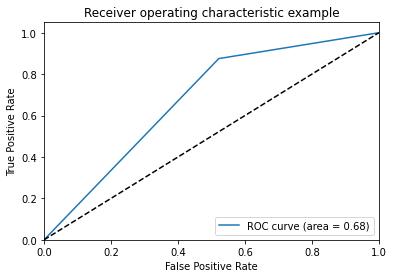

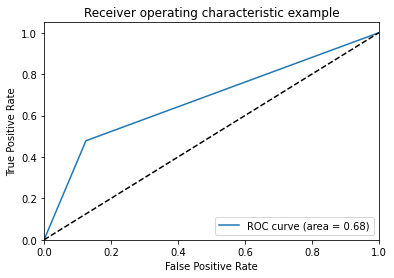

In [87]:
import matplotlib.pyplot as plt
# Plot of a ROC curve for a specific class
for i in list(LANGUAGES_N.values()):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

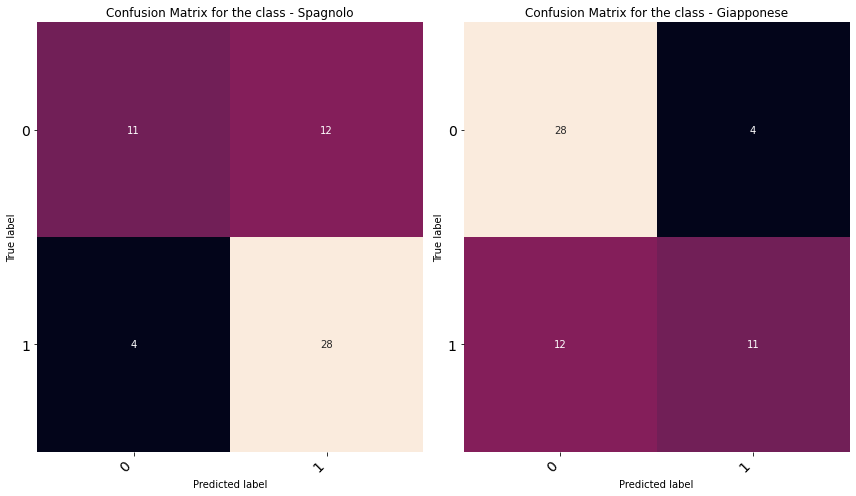

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
labels = list(LANGUAGES.values())
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, list(LANGUAGES_N.values()))
    
fig.tight_layout()
plt.show()

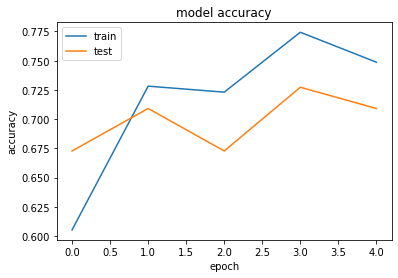

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

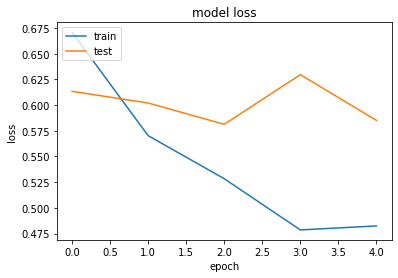

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()